In [2]:
import numpy as np
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import sys

import argparse, os, math, pickle, json

# 1) Load your model
from dual_alm_rnn_models import *
from dual_alm_rnn_exp import DualALMRNNExp
plt.rcParams['pdf.fonttype'] = '42' 


In [6]:
def get_cosine_similarity(a, b):

    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

recurrent_optimal = np.array([1.0, -1.0, -1.0, 1.0], dtype=np.float32)
recurrent_optimal_plusreadout = np.concatenate([recurrent_optimal, [-1, 1]])

# Weights analysis for small RNNs

- alignment of solutions
- adding a pre-learned hemisphere 
- adding cross-hemispheric weights

In [ ]:
exp=DualALMRNNExp()


# Load configs to get model parameters
with open('dual_alm_rnn_configs.json', 'r') as f:
    configs = json.load(f)

configs['n_neurons'] = 4
configs['random_seed'] = 3
configs['unfix_epoch'] = 1
configs['n_epochs'] = 40
configs['lr'] = 3e-3
configs['bs'] = 75
configs['sigma_input_noise'] = 0.1
configs['sigma_rec_noise'] = 0.1
model = getattr(sys.modules[__name__], configs['model_type'])(configs, \
    exp.a, exp.pert_begin, exp.pert_end, noise=True)

exp.init_sub_path(configs['train_type'])
model_path = '/Users/catherinewang/Desktop/RNN/Dual_ALM_RNN/dual_alm_rnn_models/TwoHemiRNNTanh_single_readout/train_type_asymmetric_fixed_input_mult_seeds/n_neurons_4_random_seed_3/unfix_epoch_1/n_epochs_40_n_epochs_across_hemi_0/lr_3.0e-03_bs_75/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_1.00_right_alm_amp_1.00/init_cross_hemi_rel_factor_0.20/model_epoch_30.pth'
# checkpoint_path = os.path.join(model_path.format(seed, unfix_epoch), checkpoint_file)
# if not os.path.exists(checkpoint_path):
#     raise FileNotFoundError(f"Model checkpoint not found at {checkpoint_path}")

state_dict = torch.load(model_path, map_location='cpu', weights_only=True)
model.load_state_dict(state_dict)
print(model.rnn_cell.w_hh_linear_ll.weight.data.cpu().numpy())
print(model.readout_linear.weight.data.cpu().numpy())

Fixed input weights for left and right ALM
[[ 1.5 -0.3]
 [-0.3  1.5]]
[[-2.0420127   2.0418694  -0.19284172 -0.14140457]]


# Regular training

In [4]:
weights_l_initial = np.load('test/figs/small_rnn_weights/all_recurrent_weights_l_initial.npy',allow_pickle=True)
weights_l_final = np.load('test/figs/small_rnn_weights/all_recurrent_weights_l_final.npy',allow_pickle=True)
weights_r_initial = np.load('test/figs/small_rnn_weights/all_recurrent_weights_r_initial.npy',allow_pickle=True)
weights_r_final = np.load('test/figs/small_rnn_weights/all_recurrent_weights_r_final.npy',allow_pickle=True)

all_learning_l = np.load('test/figs/small_rnn_weights/all_readout_acc_left.npy',allow_pickle=True)
all_learning_r = np.load('test/figs/small_rnn_weights/all_readout_acc_right.npy',allow_pickle=True)

Quantify learning imbalance

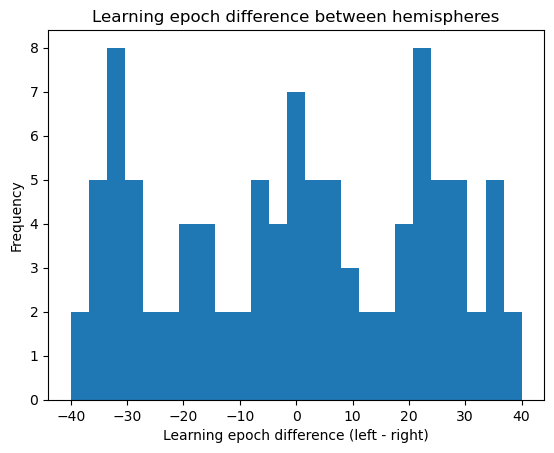

In [ ]:
all_learning_l = np.load('test/figs/small_rnn_weights/all_readout_acc_left.npy',allow_pickle=True)
all_learning_r = np.load('test/figs/small_rnn_weights/all_readout_acc_right.npy',allow_pickle=True)

learningdiff = []
all_learning_epoch_l, all_learning_epoch_r = [],[]
for i in range(100):

    # epoch where learning is reached per side
    learning_epoch_l = np.where(all_learning_l[i] > 0.7)[0]
    learning_epoch_r = np.where(all_learning_r[i] > 0.7)[0]

    learning_epoch_l = 40 if len(learning_epoch_l) == 0 else learning_epoch_l[0]
    learning_epoch_r = 40 if len(learning_epoch_r) == 0 else learning_epoch_r[0]

    all_learning_epoch_l.append(learning_epoch_l)
    all_learning_epoch_r.append(learning_epoch_r)

    learningdiff.append(learning_epoch_l-learning_epoch_r)

plt.hist(learningdiff,bins=25)
plt.title('Learning epoch difference between hemispheres')
plt.xlabel('Learning epoch difference (left - right)')
plt.ylabel('Frequency')
plt.show()

Look at the alignment of final solutions in R vs L hemi weights

Text(0, 0.5, 'Frequency')

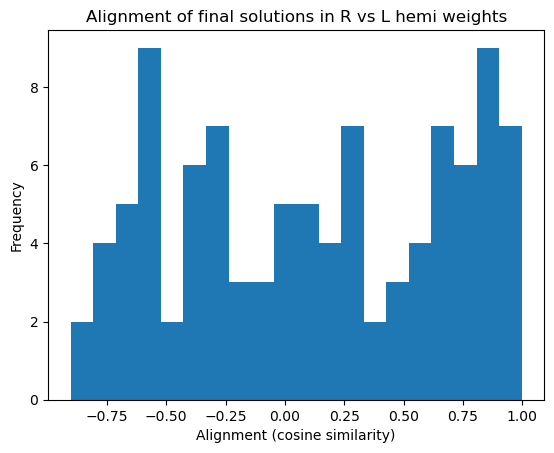

In [9]:
weights_l_final.shape, weights_r_final.shape

similarity = []
for i in range(100):
    similarity.append(get_cosine_similarity(weights_l_final[i].flatten(), weights_r_final[i].flatten()))

plt.hist(similarity,bins=20)
plt.title('Alignment of final solutions in R vs L hemi weights')
plt.xlabel('Alignment (cosine similarity)')
plt.ylabel('Frequency')

Pearson correlation coefficient between alignment and learning imbalance: -0.531
P-value: 1.35e-08


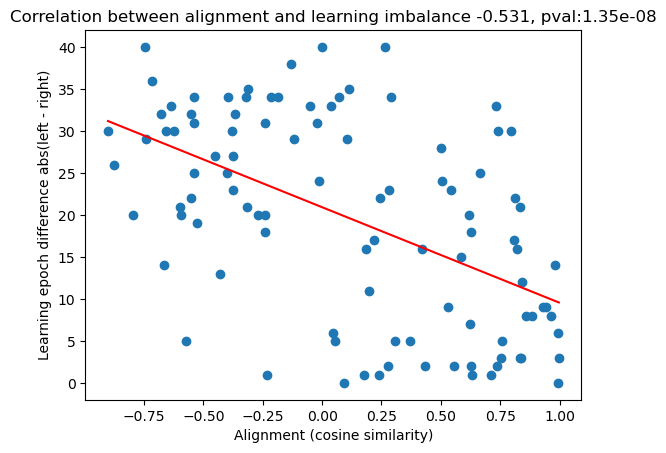

In [12]:
# Correlate alignment of two hemispheres with learning imbalance
plt.scatter(similarity, np.abs(learningdiff))
plt.xlabel('Alignment (cosine similarity)')
plt.ylabel('Learning epoch difference abs(left - right)')


from scipy.stats import pearsonr

# Compute Pearson correlation coefficient and p-value
corr_coef, p_value = pearsonr(similarity, np.abs(learningdiff))

print(f"Pearson correlation coefficient between alignment and learning imbalance: {corr_coef:.3f}")
print(f"P-value: {p_value:.3g}")
# Add regression line to the scatter plot
from numpy import polyfit, poly1d

# Fit a linear model
m, b = polyfit(similarity, np.abs(learningdiff), 1)
regression_line = poly1d([m, b])

# Sort similarity for plotting the line
sorted_idx = np.argsort(similarity)
sorted_similarity = np.array(similarity)[sorted_idx]
sorted_learningdiff = np.abs(np.array(learningdiff))[sorted_idx]

# Plot regression line
plt.plot(sorted_similarity, regression_line(sorted_similarity), color='red', label='Fit: y={:.2f}x+{:.2f}'.format(m, b))
# plt.legend()

plt.title(f'Correlation between alignment and learning imbalance {corr_coef:.3f}, pval:{p_value:.3g}')
plt.show()



Pearson correlation coefficient between alignment and learning imbalance: -0.539
P-value: 8.78e-09


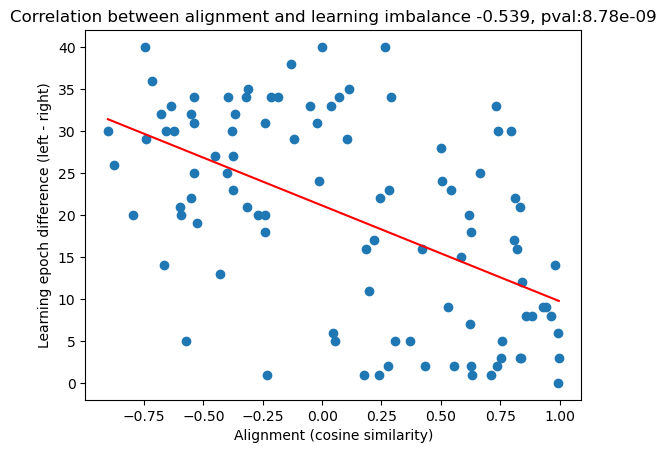

In [106]:
# Correlate alignment of two hemispheres with learning imbalance only including when both hemispheres learn
idx_both_learn = np.where((np.array(all_learning_epoch_l)<40 ) | (np.array(all_learning_epoch_r)<40))[0]
similarity = np.array(similarity)[idx_both_learn]
learningdiff = np.array(learningdiff)[idx_both_learn]
plt.scatter(similarity, np.abs(learningdiff))
plt.xlabel('Alignment (cosine similarity)')
plt.ylabel('Learning epoch difference (left - right)')


from scipy.stats import pearsonr

# Compute Pearson correlation coefficient and p-value
corr_coef, p_value = pearsonr(similarity, np.abs(learningdiff))

print(f"Pearson correlation coefficient between alignment and learning imbalance: {corr_coef:.3f}")
print(f"P-value: {p_value:.3g}")
# Add regression line to the scatter plot
from numpy import polyfit, poly1d

# Fit a linear model
m, b = polyfit(similarity, np.abs(learningdiff), 1)
regression_line = poly1d([m, b])

# Sort similarity for plotting the line
sorted_idx = np.argsort(similarity)
sorted_similarity = np.array(similarity)[sorted_idx]
sorted_learningdiff = np.abs(np.array(learningdiff))[sorted_idx]

# Plot regression line
plt.plot(sorted_similarity, regression_line(sorted_similarity), color='red', label='Fit: y={:.2f}x+{:.2f}'.format(m, b))
# plt.legend()

plt.title(f'Correlation between alignment and learning imbalance {corr_coef:.3f}, pval:{p_value:.3g}')
plt.show()



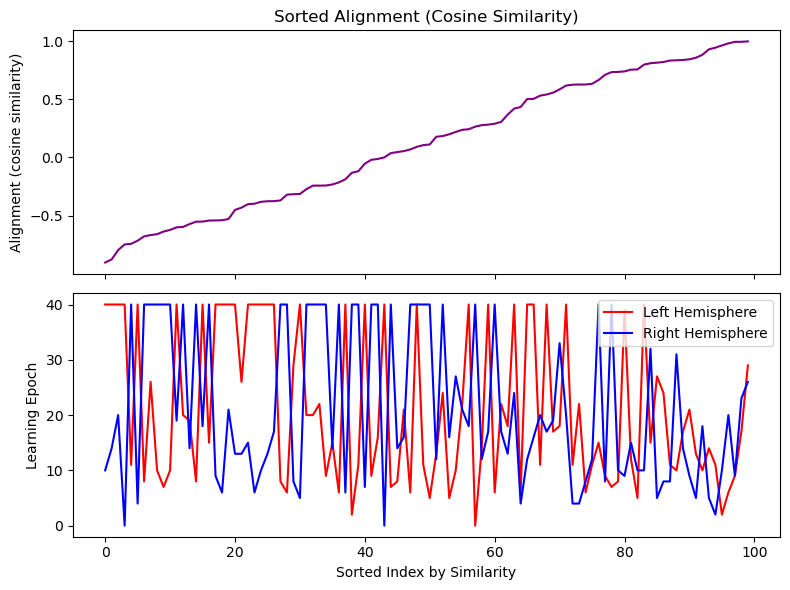

In [25]:
# learning rate if aligned or not aligned:

# all_learning_epoch_l
# similarity
import matplotlib.pyplot as plt

idx_sorted = np.argsort(similarity)

fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Plot similarity
axs[0].plot(np.array(similarity)[idx_sorted], color='purple')
axs[0].set_ylabel("Alignment (cosine similarity)")
axs[0].set_title("Sorted Alignment (Cosine Similarity)")

# Plot learning epochs for left and right hemispheres
axs[1].plot(np.array(all_learning_epoch_l)[idx_sorted], c='r', label='Left Hemisphere')
axs[1].plot(np.array(all_learning_epoch_r)[idx_sorted], c='b', label='Right Hemisphere')
axs[1].set_ylabel("Learning Epoch")
axs[1].set_xlabel("Sorted Index by Similarity")
axs[1].legend()

plt.tight_layout()
plt.show()

# plt.scatter(np.array(similarity)[idx_sorted], np.mean([np.array(all_learning_epoch_l)[idx_sorted], np.array(all_learning_epoch_r)[idx_sorted]], axis=0), c='b')
# plt.xlabel('Alignment (cosine similarity)')
# plt.ylabel('Learning epoch')
# plt.show()




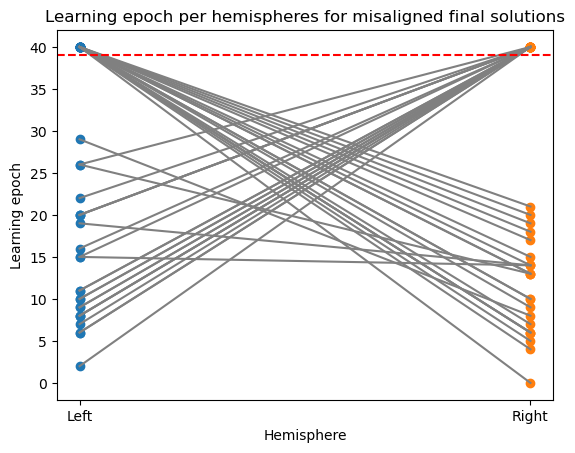

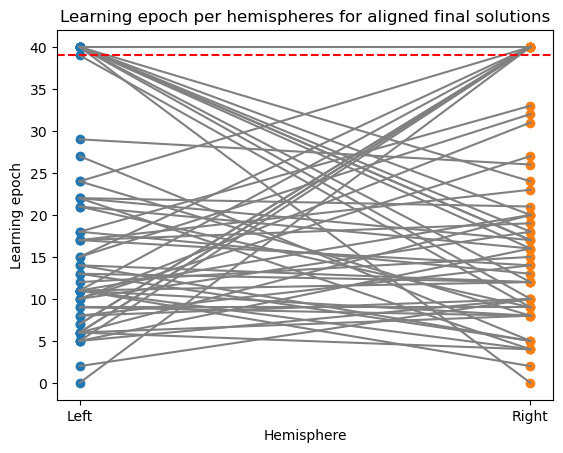

In [88]:
# how often do we see two different solutions that both learn?
idx_diff_sol = np.where(np.array(similarity)<0)[0]

plt.scatter(np.zeros(len(idx_diff_sol)), np.array(all_learning_epoch_l)[idx_diff_sol])
plt.scatter(np.ones(len(idx_diff_sol)), np.array(all_learning_epoch_r)[idx_diff_sol])

for i in idx_diff_sol:
    plt.plot([0,1], [np.array(all_learning_epoch_l)[i], np.array(all_learning_epoch_r)[i]], color='grey')
plt.axhline(39, color='red', linestyle='--')
plt.ylabel('Learning epoch')
plt.xlabel('Hemisphere')
plt.xticks([0,1], ['Left', 'Right'])
plt.title('Learning epoch per hemispheres for misaligned final solutions')
plt.show()

# negative control to: how often do we see two different solutions that both learn?
idx_diff_sol = np.where(np.array(similarity)>0)[0]

plt.scatter(np.zeros(len(idx_diff_sol)), np.array(all_learning_epoch_l)[idx_diff_sol])
plt.scatter(np.ones(len(idx_diff_sol)), np.array(all_learning_epoch_r)[idx_diff_sol])

for i in idx_diff_sol:
    plt.plot([0,1], [np.array(all_learning_epoch_l)[i], np.array(all_learning_epoch_r)[i]], color='grey')
plt.axhline(39, color='red', linestyle='--')
plt.ylabel('Learning epoch')
plt.xlabel('Hemisphere')
plt.xticks([0,1], ['Left', 'Right'])
plt.title('Learning epoch per hemispheres for aligned final solutions')
plt.show()





# Add pre-learned hemi:

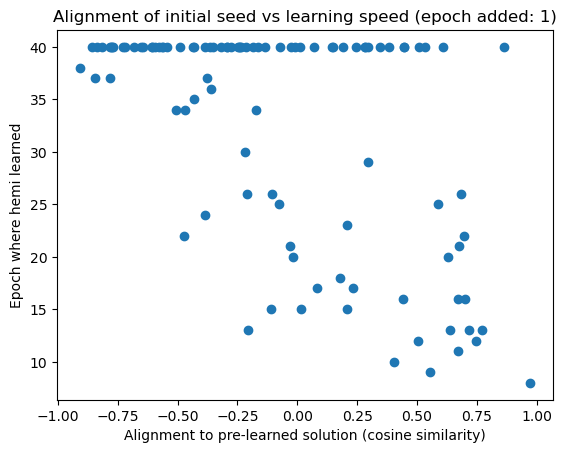

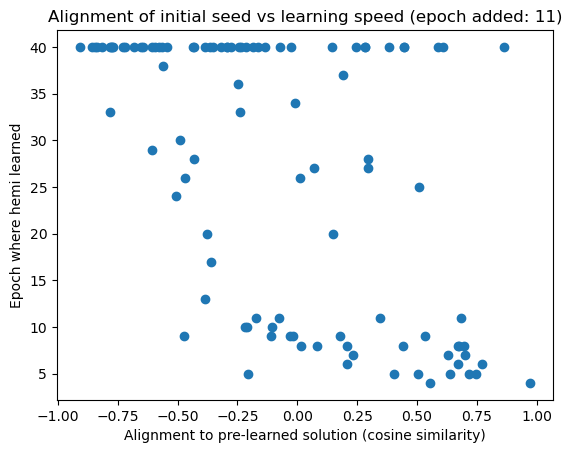

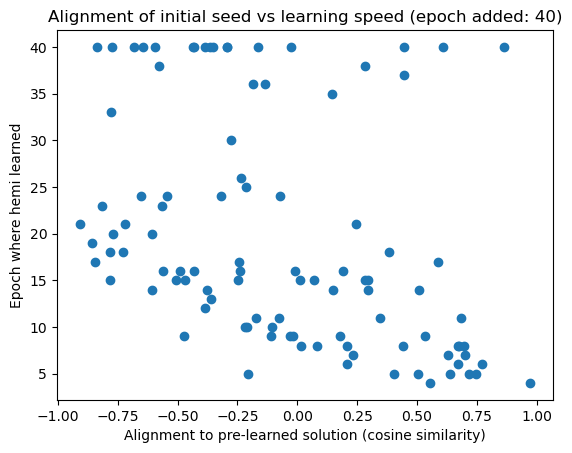

In [ ]:
all_alignments = []
for unfix_epoch in [1, 11, 40]:
    readout_bias = np.load('test/figs/epoch_{}/all_readout_bias.npy'.format(unfix_epoch))
    readout_weights = np.load('test/figs/epoch_{}/all_readout_weights.npy'.format(unfix_epoch))
    recurrent_weights = np.load('test/figs/epoch_{}/all_recurrent_weights.npy'.format(unfix_epoch))
    recurrent_bias = np.load('test/figs/epoch_{}/all_recurrent_bias.npy'.format(unfix_epoch))
    learning_epoch = np.load('test/figs/epoch_{}/all_learning_epoch.npy'.format(unfix_epoch))

    alignments = []
    for i in range(len(recurrent_weights)):
        alignments.append(get_cosine_similarity(recurrent_weights[i].flatten(), recurrent_optimal))

    plt.scatter(alignments, learning_epoch)
    plt.xlabel('Alignment to pre-learned solution (cosine similarity)')
    plt.ylabel('Epoch where hemi learned')
    plt.title('Alignment of initial seed vs learning speed (epoch added: {})'.format(unfix_epoch))
    plt.show()

    # alignments_plusreadout = []
    # for i in range(len(recurrent_weights)):
    #     alignments_plusreadout.append(get_cosine_similarity(np.concatenate([recurrent_weights[i].flatten(), readout_weights[i].flatten()[:2]]), recurrent_optimal_plusreadout))

    # plt.scatter(alignments_plusreadout, learning_epoch)
    # plt.xlabel('Alignment to pre-learned solution (cosine similarity)')
    # plt.ylabel('Epoch where hemi learned')
    # plt.title('Alignment + readout of initial seed vs learning speed (epoch added: {})'.format(unfix_epoch))
    # plt.show()
    

    # plt.plot(learning_epoch)
    # plt.title('Learning Epoch for Unfix Epoch {}'.format(unfix_epoch))
    # plt.show()

# Add cross-hemi weights

Test if alignment of hemispheres affects speed up

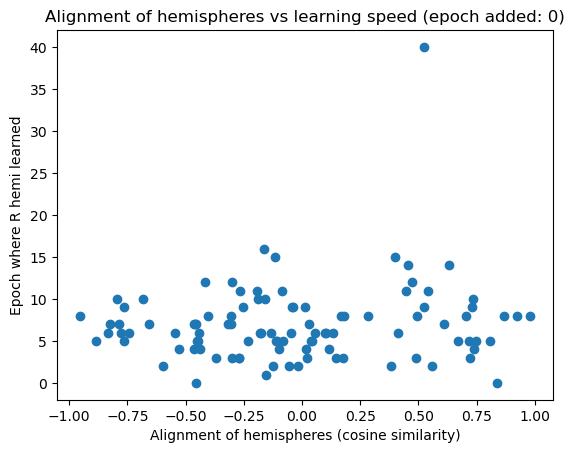

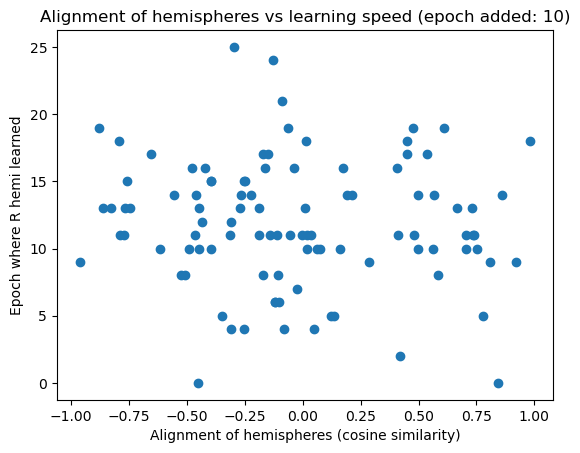

EOFError: No data left in file

In [7]:
all_alignments = []
for unfix_epoch in [0,10,20,40]:
    left_asymm, right_asymm = 1.0, 1.0
    # all_readout_bias = np.load('test/figs/crosshemi/epoch_{}/left_asymm_{}_right_asymm_{}/all_readout_bias.npy'.format(unfix_epoch, left_asymm, right_asymm))
    # np.load('test/figs/crosshemi/epoch_{}/left_asymm_{}_right_asymm_{}/all_readout_weights.npy'.format(unfix_epoch, left_asymm, right_asymm), all_readout_weights)
    recurrent_weights_r = np.load('test/figs/crosshemi/epoch_{}/left_asymm_{}_right_asymm_{}/all_recurrent_weights_r.npy'.format(unfix_epoch, left_asymm, right_asymm))
    recurrent_weights_l = np.load('test/figs/crosshemi/epoch_{}/left_asymm_{}_right_asymm_{}/all_recurrent_weights_l.npy'.format(unfix_epoch, left_asymm, right_asymm))
    # np.load('test/figs/crosshemi/epoch_{}/left_asymm_{}_right_asymm_{}/all_crosshemi_rl.npy'.format(unfix_epoch, left_asymm, right_asymm), all_crosshemi_rl)
    # np.load('test/figs/crosshemi/epoch_{}/left_asymm_{}_right_asymm_{}/all_crosshemi_lr.npy'.format(unfix_epoch, left_asymm, right_asymm), all_crosshemi_lr)
    # np.load('test/figs/crosshemi/epoch_{}/left_asymm_{}_right_asymm_{}/all_recurrent_bias.npy'.format(unfix_epoch, left_asymm, right_asymm), all_recurrent_bias)
    learning_epoch = np.load('test/figs/crosshemi/epoch_{}/left_asymm_{}_right_asymm_{}/all_learning_epoch.npy'.format(unfix_epoch, left_asymm, right_asymm))

    alignments = []
    for i in range(len(recurrent_weights)):
        alignments.append(get_cosine_similarity(recurrent_weights_r[i].flatten(), recurrent_weights_l[i].flatten()))

    plt.scatter(alignments, learning_epoch)
    plt.xlabel('Alignment of hemispheres (cosine similarity)')
    plt.ylabel('Epoch where R hemi learned')
    plt.title('Alignment of hemispheres vs learning speed (epoch added: {})'.format(unfix_epoch))
    plt.show()